<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/3_distributed_training_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

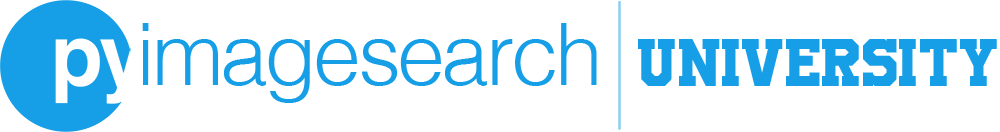

# Introduction to Distributed Training in PyTorch
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Introduction to Distributed Training in PyTorch](https://www.pyimagesearch.com/2021/10/18/introduction-to-distributed-training-in-pytorch/) blog post published on 2021-10-18.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/distributed-training-pytorch/distributed-training-pytorch.zip
!unzip -qq distributed-training-pytorch.zip
%cd distributed-training-pytorch

--2021-08-26 02:33:01--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/distributed-training-pytorch/distributed-training-pytorch.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.252.145
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.252.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27951211 (27M) [application/zip]
Saving to: ‘distributed-training-pytorch.zip’

distributed-trainin 100%[===================>]  26.66M  10.5MB/s    in 2.5s    

2021-08-26 02:33:04 (10.5 MB/s) - ‘distributed-training-pytorch.zip’ saved [27951211/27951211]

/content/distributed-training-pytorch


### Get the Food-11 dataset

In [2]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/food-datasets/Food-11.zip
!unzip -qq Food-11.zip

--2021-08-26 02:33:05--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/food-datasets/Food-11.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.170.80
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.170.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1163903300 (1.1G) [application/zip]
Saving to: ‘Food-11.zip’

Food-11.zip         100%[===================>]   1.08G  18.6MB/s    in 62s     

2021-08-26 02:34:07 (18.0 MB/s) - ‘Food-11.zip’ saved [1163903300/1163903300]



## Blog Post Code

### Import Packages

In [3]:
# import the necessary packages
from sklearn.metrics import classification_report
from torchvision.models import densenet121
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
from torchvision import transforms
from torchvision import datasets
from imutils import paths
from torch import optim
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import shutil
import torch
import time
import os

### Defining the config

In [4]:
class config:
    # define path to the original dataset
    DATA_PATH = "Food-11"

    # define base path to store our modified dataset
    BASE_PATH = "dataset"

    # define paths to separate train, validation, and test splits
    TRAIN = os.path.join(BASE_PATH, "training")
    VAL = os.path.join(BASE_PATH, "validation")
    TEST = os.path.join(BASE_PATH, "evaluation")

    # initialize the list of class label names
    CLASSES = ["Bread", "Dairy_product", "Dessert", "Egg", "Fried_food",
        "Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup",
        "Vegetable/Fruit"]

    # specify ImageNet mean and standard deviation and image size
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    IMAGE_SIZE = 224

    # set the device to be used for training and evaluation
    DEVICE = torch.device("cuda")

    # specify training hyperparameters
    LOCAL_BATCH_SIZE = 128
    PRED_BATCH_SIZE = 4
    EPOCHS = 20
    LR = 0.0001

    # define paths to store training plot and trained model
    PLOT_PATH = os.path.join("output", "model_training.png")
    MODEL_PATH = os.path.join("output", "food_classifier.pth")

### Process the dataset

In [5]:
def copy_images(rootDir, destiDir):
	# get a list of the all the images present in the directory
	imagePaths = list(paths.list_images(rootDir))
	print(f"[INFO] total images found: {len(imagePaths)}...")

	# loop over the image paths
	for imagePath in imagePaths:
		# extract class label from the filename
		filename = imagePath.split(os.path.sep)[-1]
		label = config.CLASSES[int(filename.split("_")[0])].strip()

		# construct the path to the output directory
		dirPath = os.path.sep.join([destiDir, label])

		# if the output directory does not exist, create it
		if not os.path.exists(dirPath):
			os.makedirs(dirPath)

		# construct the path to the output image file and copy it
		p = os.path.sep.join([dirPath, filename])
		shutil.copy2(imagePath, p)

	# calculate the total number of images in the destination
	# directory and print it
	currentTotal = list(paths.list_images(destiDir))
	print(f"[INFO] total images copied to {destiDir}: "
		f"{len(currentTotal)}...")

In [6]:
# copy over the images to their respective directories
print("[INFO] copying images...")
copy_images(os.path.join(config.DATA_PATH, "training"), config.TRAIN)
copy_images(os.path.join(config.DATA_PATH, "validation"), config.VAL)
copy_images(os.path.join(config.DATA_PATH, "evaluation"), config.TEST)

[INFO] copying images...
[INFO] total images found: 9866...
[INFO] total images copied to dataset/training: 9866...
[INFO] total images found: 3430...
[INFO] total images copied to dataset/validation: 3430...
[INFO] total images found: 3347...
[INFO] total images copied to dataset/evaluation: 3347...


In [7]:
# removing the Food-11 to save space
! rm -rf Food-11

### Prepare the data for training

In [8]:
# determine the number of GPUs we have
NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

# determine the batch size based on the number of GPUs
BATCH_SIZE = config.LOCAL_BATCH_SIZE * NUM_GPU
print(f"[INFO] using a batch size of {BATCH_SIZE}...")

[INFO] number of GPUs found: 1...
[INFO] using a batch size of 128...


In [9]:
def get_dataloader(rootDir, transforms, bs, shuffle=True):
	# create a dataset and use it to create a data loader
	ds = datasets.ImageFolder(root=rootDir,
		transform=transforms)
	loader = DataLoader(ds, batch_size=bs, shuffle=shuffle,
		num_workers=os.cpu_count(),
		pin_memory=True if config.DEVICE == "cuda" else False)

	# return a tuple of the dataset and the data loader
	return (ds, loader)

In [10]:
# define augmentation pipelines
trainTansform = transforms.Compose([
	transforms.RandomResizedCrop(config.IMAGE_SIZE),
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(90),
	transforms.ToTensor(),
	transforms.Normalize(mean=config.MEAN, std=config.STD)
])
testTransform = transforms.Compose([
	transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
	transforms.ToTensor(),
	transforms.Normalize(mean=config.MEAN, std=config.STD)
])

# create data loaders
(trainDS, trainLoader) = get_dataloader(config.TRAIN,
	transforms=trainTansform, bs=BATCH_SIZE)
(valDS, valLoader) = get_dataloader(config.VAL,
	transforms=testTransform, bs=BATCH_SIZE, shuffle=False)
(testDS, testLoader) = get_dataloader(config.TEST,
	transforms=testTransform, bs=BATCH_SIZE, shuffle=False)

### Create the model

In [11]:
class FoodClassifier(nn.Module):
	def __init__(self, baseModel, numClasses):
		super(FoodClassifier, self).__init__()

		# initialize the base model and the classification layer
		self.baseModel = baseModel
		self.classifier = nn.Linear(baseModel.classifier.in_features,
			numClasses)

		# set the classifier of our base model to produce outputs
		# from the last convolution block
		self.baseModel.classifier = nn.Identity()

	# we decorate the *forward()* method with *autocast()* to enable
	# mixed-precision training in a distributed manner
	@autocast()
	def forward(self, x):
		# pass the inputs through the base model and then obtain the
		# classifier outputs
		features = self.baseModel(x)
		logits = self.classifier(features)

		# return the classifier outputs
		return logits

In [12]:
# load up the DenseNet121 model
baseModel = densenet121(pretrained=True)

# loop over the modules of the model and if the module is batch norm,
# set it to non-trainable
for module, param in zip(baseModel.modules(), baseModel.parameters()):
	if isinstance(module, nn.BatchNorm2d):
		param.requires_grad = False

# initialize our custom model and flash it to the current device
model = FoodClassifier(baseModel, len(trainDS.classes))
model = model.to(config.DEVICE)

# if we have more than one GPU then parallelize the model
if NUM_GPU > 1:
	model = nn.DataParallel(model)

# initialize loss function, optimizer, and gradient scaler
lossFunc = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=config.LR * NUM_GPU)
scaler = torch.cuda.amp.GradScaler(enabled=True)

# initialize a learning-rate (LR) scheduler to decay the it by a factor
# of 0.1 after every 10 epochs
lrScheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [13]:
# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [],
	"val_acc": []}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()

for e in tqdm(range(config.EPOCHS)):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0

	# loop over the training set
	for (x, y) in trainLoader:
		with torch.cuda.amp.autocast(enabled=True):
			# send the input to the device
			(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

			# perform a forward pass and calculate the training loss
			pred = model(x)
			loss = lossFunc(pred, y)

		# calculate the gradients
		scaler.scale(loss).backward()
		scaler.step(opt)
		scaler.update()
		opt.zero_grad()

		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss.item()
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

	# update our LR scheduler
	lrScheduler.step()

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for (x, y) in valLoader:
			with torch.cuda.amp.autocast(enabled=True):
				# send the input to the device
				(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

				# make the predictions and calculate the validation
				# loss
				pred = model(x)
				totalValLoss += lossFunc(pred, y).item()

			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDS)
	valCorrect = valCorrect / len(valDS)

	# update our training history
	H["train_loss"].append(avgTrainLoss)
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss)
	H["val_acc"].append(valCorrect)

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
		avgValLoss, valCorrect))

[INFO] training the network...


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  5%|▌         | 1/20 [01:45<33:32, 105.89s/it]

[INFO] EPOCH: 1/20
Train loss: 1.325346, Train accuracy: 0.6034
Val loss: 0.770630, Val accuracy: 0.7825


 10%|█         | 2/20 [03:29<31:24, 104.70s/it]

[INFO] EPOCH: 2/20
Train loss: 0.695620, Train accuracy: 0.7877
Val loss: 0.598758, Val accuracy: 0.8227


 15%|█▌        | 3/20 [05:18<30:09, 106.46s/it]

[INFO] EPOCH: 3/20
Train loss: 0.554032, Train accuracy: 0.8272
Val loss: 0.452420, Val accuracy: 0.8676


 20%|██        | 4/20 [07:07<28:37, 107.35s/it]

[INFO] EPOCH: 4/20
Train loss: 0.491081, Train accuracy: 0.8496
Val loss: 0.422655, Val accuracy: 0.8732


 25%|██▌       | 5/20 [08:53<26:47, 107.15s/it]

[INFO] EPOCH: 5/20
Train loss: 0.428550, Train accuracy: 0.8714
Val loss: 0.377470, Val accuracy: 0.8819


 30%|███       | 6/20 [10:40<24:56, 106.92s/it]

[INFO] EPOCH: 6/20
Train loss: 0.413455, Train accuracy: 0.8727
Val loss: 0.369080, Val accuracy: 0.8866


 35%|███▌      | 7/20 [12:26<23:06, 106.64s/it]

[INFO] EPOCH: 7/20
Train loss: 0.382954, Train accuracy: 0.8828
Val loss: 0.348566, Val accuracy: 0.8915


 40%|████      | 8/20 [14:17<21:35, 107.97s/it]

[INFO] EPOCH: 8/20
Train loss: 0.361710, Train accuracy: 0.8899
Val loss: 0.369089, Val accuracy: 0.8878


 45%|████▌     | 9/20 [16:00<19:30, 106.41s/it]

[INFO] EPOCH: 9/20
Train loss: 0.353975, Train accuracy: 0.8930
Val loss: 0.313575, Val accuracy: 0.9035


 50%|█████     | 10/20 [17:52<18:03, 108.32s/it]

[INFO] EPOCH: 10/20
Train loss: 0.331032, Train accuracy: 0.8970
Val loss: 0.318663, Val accuracy: 0.8985


 55%|█████▌    | 11/20 [19:49<16:37, 110.88s/it]

[INFO] EPOCH: 11/20
Train loss: 0.290162, Train accuracy: 0.9148
Val loss: 0.314606, Val accuracy: 0.9026


 60%|██████    | 12/20 [21:32<14:28, 108.55s/it]

[INFO] EPOCH: 12/20
Train loss: 0.286455, Train accuracy: 0.9140
Val loss: 0.306293, Val accuracy: 0.9041


 65%|██████▌   | 13/20 [23:19<12:35, 107.99s/it]

[INFO] EPOCH: 13/20
Train loss: 0.268928, Train accuracy: 0.9217
Val loss: 0.295294, Val accuracy: 0.9079


 70%|███████   | 14/20 [25:00<10:36, 106.06s/it]

[INFO] EPOCH: 14/20
Train loss: 0.271574, Train accuracy: 0.9213
Val loss: 0.299951, Val accuracy: 0.9058


 75%|███████▌  | 15/20 [26:44<08:46, 105.21s/it]

[INFO] EPOCH: 15/20
Train loss: 0.260689, Train accuracy: 0.9212
Val loss: 0.300779, Val accuracy: 0.9044


 80%|████████  | 16/20 [28:28<07:00, 105.04s/it]

[INFO] EPOCH: 16/20
Train loss: 0.256542, Train accuracy: 0.9223
Val loss: 0.289932, Val accuracy: 0.9090


 85%|████████▌ | 17/20 [30:15<05:16, 105.44s/it]

[INFO] EPOCH: 17/20
Train loss: 0.270809, Train accuracy: 0.9179
Val loss: 0.290182, Val accuracy: 0.9073


 90%|█████████ | 18/20 [32:00<03:30, 105.29s/it]

[INFO] EPOCH: 18/20
Train loss: 0.253531, Train accuracy: 0.9250
Val loss: 0.287381, Val accuracy: 0.9073


 95%|█████████▌| 19/20 [33:42<01:44, 104.28s/it]

[INFO] EPOCH: 19/20
Train loss: 0.260650, Train accuracy: 0.9223
Val loss: 0.291579, Val accuracy: 0.9067


100%|██████████| 20/20 [35:40<00:00, 107.00s/it]

[INFO] EPOCH: 20/20
Train loss: 0.246874, Train accuracy: 0.9287
Val loss: 0.288096, Val accuracy: 0.9070


[INFO] total time taken to train the model: 2140.11s
[INFO] evaluating network...
               precision    recall  f1-score   support

        Bread       0.94      0.85      0.89       368
Dairy_product       0.87      0.82      0.84       148
      Dessert       0.85      0.93      0.89       500
          Egg       0.92      0.91      0.91       335
   Fried_food       0.93      0.92      0.92       287
         Meat       0.94      0.94      0.94       432
      Noodles       0.96      0.99      0.98       147
         Rice       0.97      0.97      0.97        96
      Seafood       0.96      0.92      0.94       303
         Soup       0.96      0.98      0.97       500
    Vegetable       0.97      0.96      0.97       231

     accuracy                           0.93      3347
    macro avg       0.93      0.93      0.93      3347
 weighted avg       0.93      0.93      0.93      3347



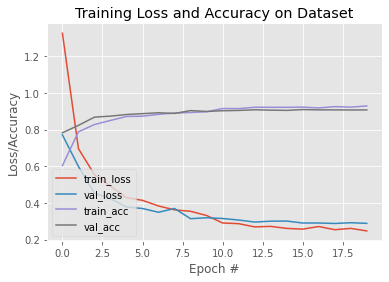

In [14]:
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# evaluate the network
print("[INFO] evaluating network...")
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()

	# initialize a list to store our predictions
	preds = []

	# loop over the test set
	for (x, _) in testLoader:
		# send the input to the device
		x = x.to(config.DEVICE)

		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

# generate a classification report
print(classification_report(testDS.targets, preds,
	target_names=testDS.classes))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)

# serialize the model state to disk
torch.save(model.state_dict(), config.MODEL_PATH)

### Inference

In [15]:
# determine the number of GPUs we have
NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

# determine the batch size based on the number of GPUs
BATCH_SIZE = config.PRED_BATCH_SIZE * NUM_GPU
print(f"[INFO] using a batch size of {BATCH_SIZE}...")

# define augmentation pipeline
testTransform = transforms.Compose([
	transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
	transforms.ToTensor(),
	transforms.Normalize(mean=config.MEAN, std=config.STD)
])

[INFO] number of GPUs found: 1...
[INFO] using a batch size of 4...


In [16]:
# calculate the inverse mean and standard deviation
invMean = [-m/s for (m, s) in zip(config.MEAN, config.STD)]
invStd = [1/s for s in config.STD]

# define our de-normalization transform
deNormalize = transforms.Normalize(mean=invMean, std=invStd)

# create test data loader
(testDS, testLoader) = get_dataloader(config.TEST,
	transforms=testTransform, bs=BATCH_SIZE, shuffle=True)

# load up the DenseNet121 model
baseModel = densenet121(pretrained=True)

# initialize our food classifier
model = FoodClassifier(baseModel, len(testDS.classes))

# load the model state
model.load_state_dict(torch.load(config.MODEL_PATH))

# if we have more than one GPU then parallelize the model
if NUM_GPU > 1:
	model = nn.DataParallel(model)

# move the model to the device and set it in evaluation mode
model.to(config.DEVICE)
model.eval()

FoodClassifier(
  (baseModel): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mom

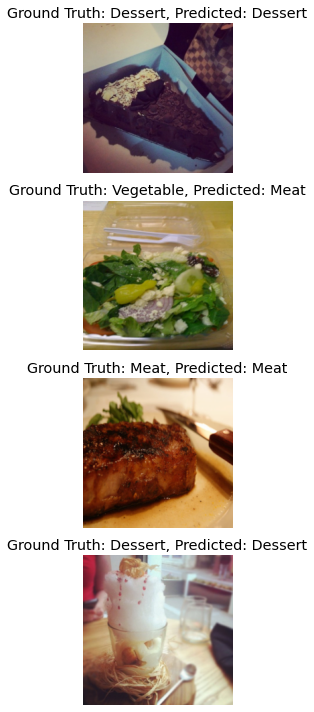

In [17]:
# grab a batch of test data
batch = next(iter(testLoader))
(images, labels) = (batch[0], batch[1])

# initialize a figure
fig = plt.figure("Results", figsize=(10, 10 * NUM_GPU))

# switch off autograd
with torch.no_grad():
	# send the images to the device
	images = images.to(config.DEVICE)

	# make the predictions
	preds = model(images)

	# loop over all the batch
	for i in range(0, BATCH_SIZE):
		# initalize a subplot
		ax = plt.subplot(BATCH_SIZE, 1, i + 1)

		# grab the image, de-normalize it, scale the raw pixel
		# intensities to the range [0, 255], and change the channel
		# ordering from channels first tp channels last
		image = images[i]
		image = deNormalize(image).cpu().numpy()
		image = (image * 255).astype("uint8")
		image = image.transpose((1, 2, 0))

		# grab the ground truth label
		idx = labels[i].cpu().numpy()
		gtLabel = testDS.classes[idx]

		# grab the predicted label
		pred = preds[i].argmax().cpu().numpy()
		predLabel = testDS.classes[pred]

		# add the results and image to the plot
		info = "Ground Truth: {}, Predicted: {}".format(gtLabel,
			predLabel)
		plt.imshow(image)
		plt.title(info)
		plt.axis("off")

	# show the plot
	plt.tight_layout()
	plt.show()

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Introduction to Distributed Training in PyTorch*](https://www.pyimagesearch.com/2021/10/18/introduction-to-distributed-training-in-pytorch/) published on 2021-10-18.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```